# Introduction-Data-Science Task 3

Lena Breitberg, Doreen Mack, David Riethmann

---

# Setup

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn._config import set_config
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from lazypredict.Supervised import LazyRegressor

import helpers
set_config(transform_output="pandas")
%matplotlib inline

### Load Data

Zunächst laden wir sowohl die Trainings-, als auch die Testdaten in `DataFrames`.

In [2]:
test_data = pd.read_csv('../data/BikeRentalDaily_test.csv', sep=';', index_col='instant')
train_data = pd.read_csv('../data/BikeRentalDaily_train.csv', sep=';', index_col='instant')

## Pipeline

Wir wenden nun den `datetime`-Converter erneut auf die Daten an.

In [3]:
datetime_converter = helpers.DatetimeConverter(target_column='dteday', date_format='%d.%m.%Y')

In [4]:
test_data = datetime_converter.transform(test_data)
train_data = datetime_converter.transform(train_data)

Im Anschluss führen wir die finalen Schritte des Preprocessing aus Taks 2 durch.

In [5]:
season_imputer = helpers.SeasonImputer(target_column='season', date_column='dteday')
correct_weekday = helpers.WeekdayMapper(target_column='weekday', date_column='dteday')
windspeed_mean_imputer = helpers.ThresholdImputer(target_column='windspeed', threshold=0.0)
column_name_transformer = FunctionTransformer(helpers.clean_column_names)
weekend_group = helpers.GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0', 'weekday_6']})
weekday_group = helpers.GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5']})

In [6]:
feature_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, dtype=int), ['season', 'weekday']),
    (OneHotEncoder(sparse_output=False, drop='first', dtype=int), ['weathersit']),
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), ['hum']),
    (StandardScaler(), ['atemp', 'windspeed', 'leaflets']),
    ('drop', ['temp', 'workingday', 'mnth', 'dteday','cnt', 'casual', 'registered']),
    remainder='passthrough'
)

In [7]:
preprocessing_pipeline = make_pipeline(
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    column_name_transformer,
    weekend_group,
    weekday_group
)

### Remove Outlier

Wir entfernen nun die Ausreißer und speichern die um Ausreißer bereinigten Daten in den Variablen `test_data_no` und `train_data_no`.

In [8]:
outlier_remover = helpers.OutlierRemover(target='cnt', threshold=3.0)

In [9]:
train_data_no = outlier_remover.fit_transform(train_data)
test_data_no = outlier_remover.fit_transform(test_data)

596 rows remaining after removing outliers.
131 rows remaining after removing outliers.


## Split Data

In den folgenden Codezellen splitten wir sowohl die Trainingsdaten mit Ausreißern, als auch die Trainingsdaten ohne Ausreißer in `train` und `validate`.

In [10]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data, train_data['cnt'], test_size=0.2, random_state=42)

In [11]:
X_train_no, X_validate_no, y_train_no, y_validate_no = train_test_split(train_data_no, train_data_no['cnt'], test_size=0.2, random_state=42)

## Performance Measures

### Helpers

Für das weitere Vorgehen definieren wir einige Funktionen, die uns dabei helfen, die verschiedenen Modelle zu evaluieren.

Zunächst definieren wir `plot_comparative_bar_charts`. Die Funktion wird später aufgerufen, um die Performance aller Modelle innerhalb von Task 3 miteinander vergleichen zu können.

In [12]:
def plot_comparative_bar_charts(df, metrics):
    """
    Plots bar charts for each metric in the given dataframe.

    Args:
    df : DataFrame
        DataFrame containing the metrics for different models.
    metrics : list
        List of metrics to plot.

    Returns:
    None
    """
    num_metrics = len(metrics)
    # Adjust the subplot layout to have metrics plotted below each other
    fig, axs = plt.subplots(num_metrics, 1, figsize=(8, 6 * num_metrics))  # Adjust figsize as needed

    for i, metric in enumerate(metrics):
        # Use 'barh' for horizontal bars
        df.plot(kind='barh', y=metric, ax=axs[i], legend=False)
        axs[i].set_title(metric)
        axs[i].set_xlabel(metric)  # X-axis now represents the metric value
        axs[i].set_ylabel('Models')  # Y-axis represents the models

    plt.tight_layout()
    plt.show()
    
# Metrics to compare
metrics = ["R2", "MAE"]
hyperparameter_selection_measures = {}
feature_selection_measures = {}

Zusätzlich dazu wird die Funktion `plot_feature_importance` definiert. Mit Hilfe dieser Funktion können wir die Bedeutung der verschiedenen Features in einem Modell visualisieren.
Abhängig vom Modelltyp wird entweder `feature_importance` oder `coef` verwendet.

In [13]:
def plot_feature_importance(reg, X_test, y_test, X_train):
    if hasattr(reg, 'feature_importances_'):
        feature_importance = reg.feature_importances_
    else:
        feature_importance = reg.coef_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
    plt.title("Feature Importance (MDI)")

    result = permutation_importance(
        reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(X_train.columns)[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()

### Funktionen

Um die Performance Measures für jedes Modell zu kalkulieren, führen wir die Funktion `performance_measures` ein.

In [14]:
def performance_measures(y_true, y_pred, n_predictors) -> tuple:
    """
    Calculate R2, Adjusted R2, and MAE
    
    Args:
        y_true: array-like, True values
        y_pred: array-like, Predicted values
        n_predictors: int, number of predictors used in the model excluding the intercept
        
    Returns:
        r2: float, R2 score
        adjusted_r2: float, Adjusted R2 score
        mae: float, Mean Absolute Error
    """
    n = len(y_true)  # Number of observations
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_predictors - 1))
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    measures = {
        "R2": r2,
        "Adjusted_R2": adjusted_r2,
        "MAE": mae,
        "RMSE": rmse
    }

    print(f"R2: {r2:.2f}")
    print(f"Adjusted R2: {adjusted_r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return measures



Die Funktion `actualVsPredictChart` ermöglicht es uns später, die Performance des Modells zu visualisieren und die tatsächlichen Werte den vorhergesagten Werten gegenüberzustellen.

In [15]:
def actualVsPredictChart(true_v, pred_v, model: str = ""):
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    # Create a lineplot with Seaborn
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title(f"{model} Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

# 1 Baseline Model

Wir beginnen zunächst wieder mit unserem `Baseline Model` aus Task 2.

### Pipeline

In [16]:
baseline = make_pipeline(
    preprocessing_pipeline,
    LinearRegression()
)

### Evaluation

In [17]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('seasonimputer',
                                  SeasonImputer(date_column='dteday',
                                                target_column='season')),
                                 ('weekdaymapper',
                                  WeekdayMapper(date_column='dteday',
                                                target_column='weekday')),
                                 ('thresholdimputer',
                                  ThresholdImputer(target_column='windspeed')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehote...
                                  FunctionTransformer(func=<function clean_column_names at 0x7f4a21903100>)),
                                 ('grouponehotencodedtransformer-1',
                                  GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0',
                                                                                           'weekday_6']})),
                                 ('grouponehotencodedtransformer-2',
                                  GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                                           'weekday_2',
                                                                                           'weekday_3',
                                                                                           'weekday_4',
                                                                                           'weekday_5']}))])),
                ('linearregression', LinearRegression())])

In [18]:
y_pred = baseline.predict(X_validate)

In [19]:
measures = performance_measures(y_validate, y_pred, len(baseline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.11
MAE: 1263.70
RMSE: 4160.70


Um einen guten Vergleich zwischen der Performance ohne Outlier zu haben, wird hier das Ergebnis aus Task 2 für das Baseline Modell ohne Outlier in den Dataframe geschrieben.

In [20]:
hyperparameter_selection_measures["Baseline"] = {'R2': measures['R2'], 'MAE': measures['MAE']}
hyperparameter_selection_measures["Baseline_NO"] = {'R2': 0.86, 'MAE': 546.61}
feature_selection_measures["Baseline"] = {'R2': measures['R2'], 'MAE': measures['MAE']}
feature_selection_measures["Baseline_NO"] = {'R2': 0.86, 'MAE': 646.61}

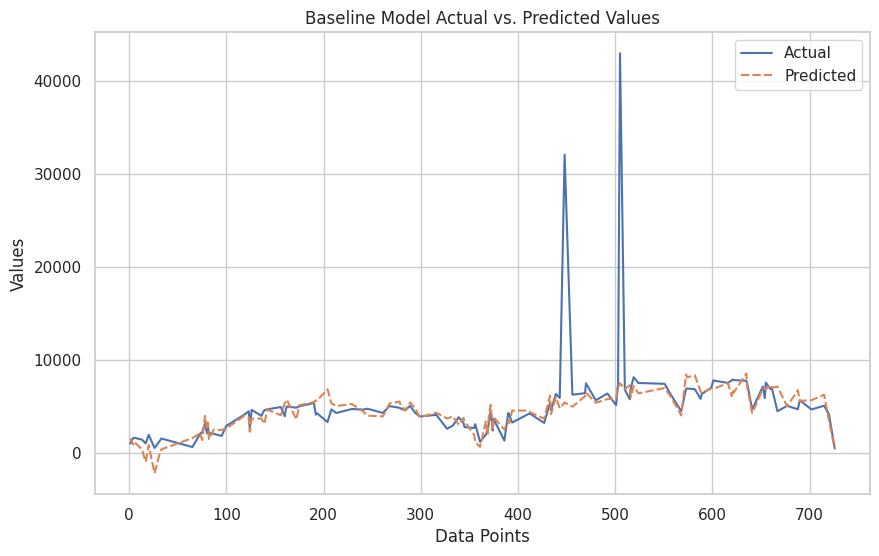

In [21]:
actualVsPredictChart(y_validate, y_pred, "Baseline Model")

# 2 Initial Model Selection

In diesem Abschnitt möchten wir alternative Modelle in Betracht ziehen. 

Für die Evaluierung verschiedener Algorithmen nutzen wir die Bibliothek `Lazy Predict` bzw. aus dieser Bibliothek den `Lazy Regressor`. Diese wurde von Shankar Rao Pandala entwickelt. Es handelt sich um eine Wrapper-Bibliothek, die auf vielen verschiedenen Machine Learning Bibliotheken und -Algorithmen basiert.
Der `Lazy Regressor` automatisiert den Auswahlprozess geeigneter Regressionsmodelle, indem eine Vielzahl von Modellen auf den vorliegenden Datensatz angewandt wird. Dieser wird zuvor durch minimales Preprocessing für den Auswahlprozess vorbereitet z.B. mittels Scaling und Imputation. 
Im Anschluss werden die Modelle anhand der gängigen Metriken, in unserem Fall `R-Squared` und `RMSE` bewertet. Es ist wichtig zu beachten, dass kein automatisiertes Hyperparamter Tuning durchgeführt wird.
Dieses Vorgehen bietet vor allem den Vorteil, dass des gesamte Prozess automatisiert abläuft und die Bibliothek sehr einfach anzuwenden ist. Zusätzlich wird eine erhebliche Zeitersparnis ermöglicht.

Um Data Leakage während der Evaluierung zu vermeinden, wird die Pipeline nur mit den Trainingsdaten gefitted. 

Die Anwendung der Pipelineschritte auf die Test- und Validierungsdaten geschieht unter Verwendung der aus den Trainingsdaten gelernten Werte.

## Helpers

In [22]:
def visualize_lazy_predictions(models, predictions, y_validate, n_predictors: int):
    """
    Visualize the predictions from the lazy regressor

    Args:
        predictions: dict, predictions from the lazy regressor
    """
    models = models.sort_values(by='R-Squared', ascending=False)
    for model_name in models.iloc[: 2].index:
        y_pred = predictions[model_name].to_list()
        _ = performance_measures(y_validate, y_pred, n_predictors)
        actualVsPredictChart(y_validate, y_pred, model_name)

## 2.1 With Outlier

Für das weitere Vorgehen ist zu beachten, dass wir jeweils einmal die um Ausreißer bereinigten Daten und einmal die nicht um Ausreißer bereinigten Daten verwenden werden.

So soll der Einfluss der Aureißer und die Auswirkung auf die Performance der Modelle transparent dargestellt werden.

### 2.1.1 Anwendung des Lazy Regressor

Wir starten mit den Daten, die die Ausreißer noch beinhalten und wenden den `Lazy Regressor` an.

In [23]:
X_train = preprocessing_pipeline.fit_transform(X_train)
X_validate = preprocessing_pipeline.transform(X_validate)

In [24]:
lazy_regressor = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = lazy_regressor.fit(X_train, X_validate, y_train, y_validate)

100%|██████████| 42/42 [00:03<00:00, 12.21it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 13
[LightGBM] [Info] Start training from score 4632.100000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Im Data Frame `models` sind die Metriken der jeweiligen Modelltypen zu sehen. Zu erkennen ist, dass der `RANSACRegressor` nach allen Metriken die beste Performance erzielt. Ein weiteres gut abschneidendes Modell ist der `HuberRegressor`. 

Für das Hyperparameter Tuning und die Feature Selection werden der `RANSACRegressor` und der `HuberRegressor` näher betrachtet.

In [25]:
models.head()

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,0.14,0.25,4079.76,0.03
HuberRegressor,0.13,0.24,4098.44,0.02
PassiveAggressiveRegressor,0.13,0.24,4103.23,0.02
BaggingRegressor,0.13,0.24,4108.38,0.03
HistGradientBoostingRegressor,0.12,0.23,4126.73,0.12


### 2.1.2 Visualization

Im Folgenden werden die zwei Modelle visualisiert. Die Performance ist eher mäßig, da die Ausreißer in den Testdaten nicht abgebildet werden können.

R2: 0.25
Adjusted R2: 0.14
MAE: 1079.83
RMSE: 4079.76


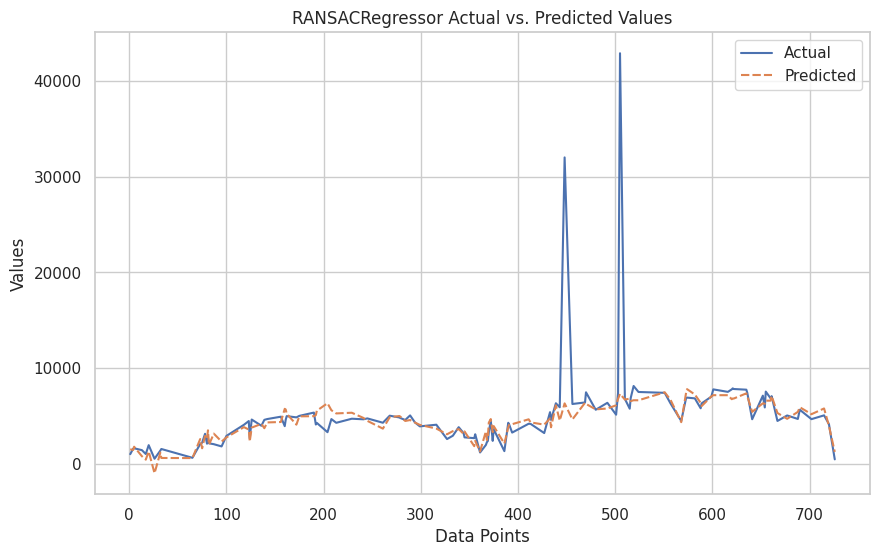

R2: 0.24
Adjusted R2: 0.13
MAE: 1086.14
RMSE: 4098.44


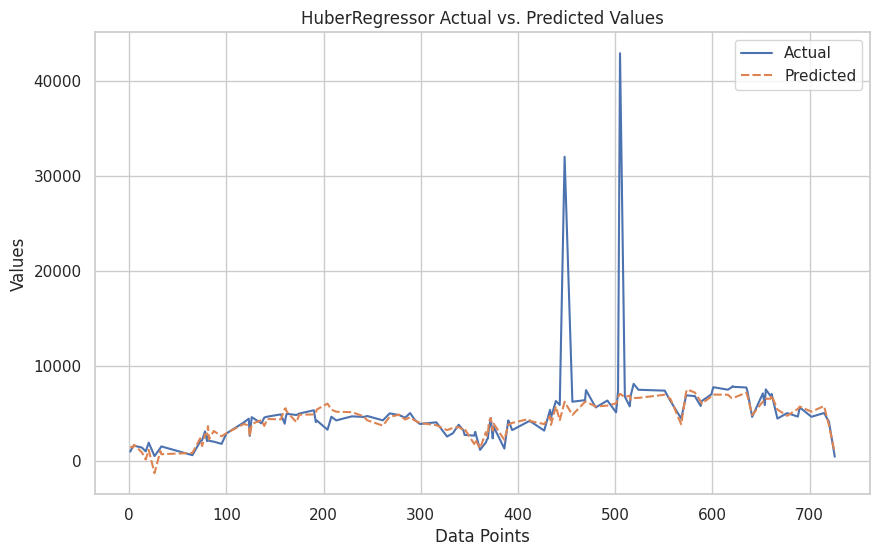

In [26]:
visualize_lazy_predictions(models, predictions, y_validate, X_train.shape[1])

## 2.2 Without Outlier

### 2.2.1 Anwendung des Lazy Regressor

Nun wenden wir den `Lazy Regressor` nochmals auf die um Ausreißer bereinigten Daten an.

In [27]:
X_train_no = preprocessing_pipeline.fit_transform(X_train_no)
X_validate_no = preprocessing_pipeline.transform(X_validate_no)

In [28]:
lazy_regressor_no = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models_no, predictions_no = lazy_regressor_no.fit(X_train_no, X_validate_no, y_train_no, y_validate_no)

100%|██████████| 42/42 [00:03<00:00, 11.23it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 476, number of used features: 13
[LightGBM] [Info] Start training from score 4459.361345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Im Data Frame `model` sind die Metriken der jeweiligen Modelltypen zu sehen. Die zwei performantesten Modelle sind der `GradientBoostingRegressor` und der `PassiveAggressiveRegressor`. 

Für das Hyperparameter Tuning und die Feature Selection werden diese zwei Modelle näher betrachtet.

In [29]:
models_no.head()

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.86,0.88,654.56,0.19
PassiveAggressiveRegressor,0.85,0.87,673.74,0.02
ExtraTreesRegressor,0.85,0.87,675.26,0.12
HuberRegressor,0.85,0.87,678.41,0.02
LassoLarsIC,0.84,0.86,685.01,0.01


### 2.2.2 Visualization

Auch diese zwei Modelle werden nun visualisiert. Die Performance ist aufgrund der entfernten Ausreißer deutlich besser.

R2: 0.88
Adjusted R2: 0.86
MAE: 501.99
RMSE: 654.56


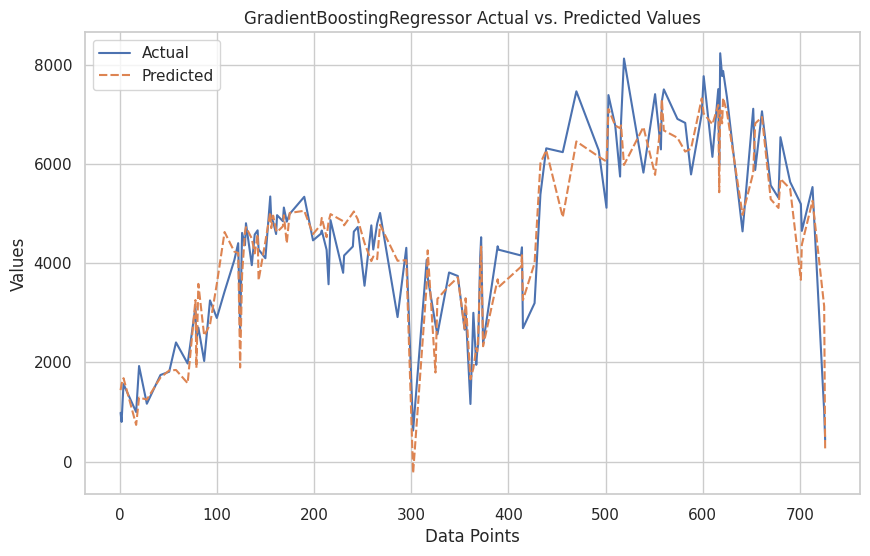

R2: 0.87
Adjusted R2: 0.85
MAE: 540.17
RMSE: 673.74


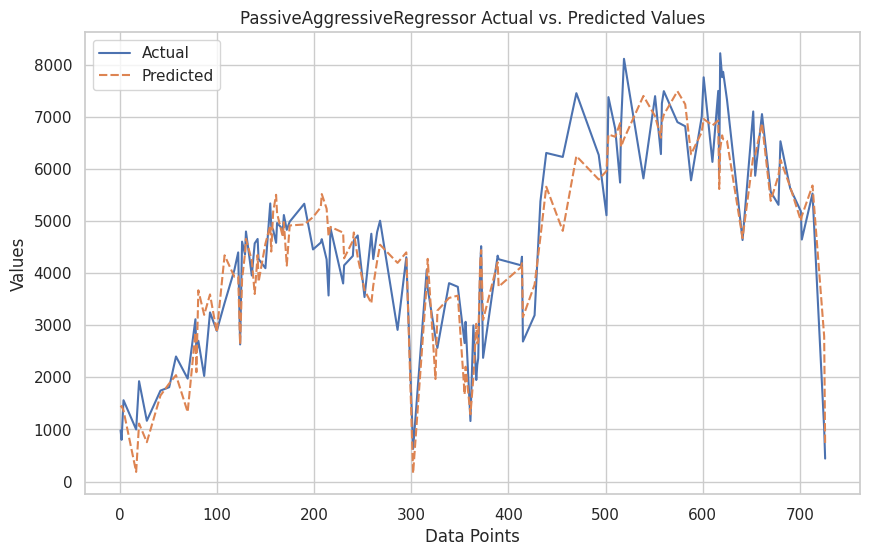

In [30]:
visualize_lazy_predictions(models_no, predictions_no, y_validate_no, X_train_no.shape[1])

# 3 Hyperparamter Tuning

Im Folgenden verwenden wir die Methode `Grid Search`, um verschiedene Kombinationen von Hyperparametern für die ausgewählten Algorithmen auszuprobieren und so jeweils die beste Leistung des Modells zu erzielen.

Bei der `Grid Search` werden für ausgewählte Hyperparameter mögliche Werte definiert, um dann alle möglichen Kombinationen dieser Werte auszuprobieren. Diese Kombinationen werden in einem Raster (Grid) organisiert, wobei jede Zeile oder Spalte des Rasters eine andere Hyperparameter-Kombination repräsentiert.

Die Bewertungsmetrik, die für die Bewertung der Modellleistung verwendet wird, ist es der `neg_mean_absolute_error`. Bei der Suche wird nach der Kombination von Hyperparametern gesucht, die die Bewertungsmetrik minimiert.

Wir sind dabei so vorgegangen, dass wir zunächst die Hyperparameter ausgewählt haben, von denen wir ausgehen, dass sie den größten Stellhebel für die Verbesserung des Modells haben.

Wir haben im Anschluss verschiedenste mögliche Werte für die einzelnen Parameter getestet, um dann im zweiten Schritt nochmal ein Fine-Tuning durchzuführen und die Wertebereiche etwas genauer einzugrenzen.

## 3.1 With Outliers

### 3.1.1 RANSACRegressor

Der `RANSACRegressor` ist ein robuster Regressionsalgorithmus, der speziell entwickelt wurde, um mit Datensätzen zu arbeiten, die Ausreißer oder fehlerhafte Datenpunkte enthalten. Der Algorithmus verwendet eine iterative Vorgehensweise, bei der er zufällige Untergruppen von Datenpunkten auswählt, ein Modell anhand dieser Untergruppen anpasst und dann die Anzahl der Inlier (Datenpunkte, die zum Modell passen) berechnet. Der Prozess wird wiederholt, und das Modell mit den meisten Inliern wird ausgewählt.

#### Hyperparameter

Für den `RANSACRegressor` ziehen wir folgende Hyperparameter in Betracht:

- **min_samples**: Dieser Parameter definiert die Mindestanzahl von Datenpunkten, die für die Bildung eines Konsensuses erforderlich sind. Zur Auswahl sind hier 50%, 60% oder 70% der Gesamtzahl der Datenpunkte.
- **max_trials**: Hier wird die maximale Anzahl von Iterationen festgelegt, die der RANSAC-Algorithmus durchführt.
- **stop_probability**: Dieser Parameter stellt die Wahrscheinlichkeit dar, mit der der Algorithmus aufhört, nach Konsens zu suchen, wenn der aktuelle Konsensus ausreicht. Je höher die Wahrscheinlichkeit, desto mehr Vertrauen hat der Algorithmus, dass der gefundene Konsensus ausreichend repräsentativ ist.
- **loss**: Loss bezeichnet die Definition der Verlustfunktion, die minimiert werden soll, um das optimale Modell zu finden. Zur Auswahl stehen die Optionen `absolute_error` (Minimierung des absoluten Fehlers) und `squared_error` (Minimierung des quadratischen Fehlers).

#### Grid Search

In [31]:
base_estimator = LinearRegression()
ransac_regressor = RANSACRegressor(estimator=base_estimator, random_state=42)

In [32]:
param_grid = {
    'min_samples': [0.5, 0.6, 0.7],  
    'max_trials': [100, 150, 200], 
    'stop_probability': [0.9, 0.99], 
    'loss': ['absolute_error', 'squared_error'],  
}

In [33]:
grid_search = GridSearchCV(ransac_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

In [34]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=RANSACRegressor(estimator=LinearRegression(),
                                       random_state=42),
             n_jobs=-1,
             param_grid={'loss': ['absolute_error', 'squared_error'],
                         'max_trials': [100, 150, 200],
                         'min_samples': [0.5, 0.6, 0.7],
                         'stop_probability': [0.9, 0.99]},
             scoring='neg_mean_absolute_error', verbose=1)

In [35]:
best_params = pd.DataFrame(grid_search.best_params_, index=['Best Parameters'])

Die `Grid Search` ergibt das folgende Ergebnis. Wir werden nun für das weitere Vorgehen die für die jeweiligen Hyperparameter ermittelten Werte verwenden.

In [36]:
pd.set_option('display.float_format', '{:.2f}'.format)
best_params.T

,Best Parameters
loss,absolute_error
max_trials,150
min_samples,0.60
stop_probability,0.90


In [37]:
pd.reset_option('display.float_format')

#### Validation

Im Anschluss evaluieren wir das Modell unter Verwendung der festgelegten Werte für die Hyperparameter.

In [38]:
ransac_regressor = RANSACRegressor(estimator=LinearRegression(), loss='absolute_error', max_trials=150, min_samples=0.6, stop_probability=0.9, random_state=42)

In [39]:
ransac_regressor.fit(X_train, y_train)

RANSACRegressor(estimator=LinearRegression(), max_trials=150, min_samples=0.6,
                random_state=42, stop_probability=0.9)

In [40]:
y_pred = ransac_regressor.predict(X_validate)

In [41]:
measures = performance_measures(y_validate, y_pred, len(ransac_regressor.estimator_.coef_))

R2: 0.25
Adjusted R2: 0.14
MAE: 1083.10
RMSE: 4091.47


In [42]:
hyperparameter_selection_measures["GridSearch_RANSAC"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

### 3.1.2 HuberRegressor

Der `HuberRegressor` kombiniert die Ideen von Least Squares Regression und der Robustheit von M-estimators. Er minimiert eine abgestufte Verlustfunktion, die zwischen einem quadratischen Verlust für kleine Residuen und einem linearen Verlust für große Residuen umschaltet. Dies macht den Huber Regressor robuster gegenüber Ausreißern im Vergleich zur reinen Least Squares Regression. 

#### Hyperparameter

Für den `HuberRegressor` ziehen wir folgende Hyperparameter in Betracht:

- **epsilon**: Der Parameter epsilon definiert die Schwelle für den Übergang von linearem zu quadratischem Verlust im `HuberRegressor`. Größere Werte führen zu einem größeren Bereich mit linearem Verlust und machen den Huber Regressor robuster gegenüber Ausreißern, während kleinere Werte den Übergang zu quadratischem Verlust früher erfolgen lassen und das Modell empfindlicher gegenüber Ausreißern machen.
- **alpha**: Der Hyperparameter alpha steuert den Punkt, an dem der Verlust zwischen quadratisch und linear wechselt bzw. die Stärke der Regularisierung, wobei größere Werte zu stärkerer Regularisierung führen.
- **max_iter**: Dieser Parameter gibt die maximale Anzahl der Iterationen an, die der Algorithmus durchführt, um zu konvergieren.
- **tol**: Die Toleranz definiert das Konvergenzkriterium für den Algorithmus. Die Berechnung wird als konvergiert betrachtet, wenn der relative Unterschied zwischen aufeinanderfolgenden Iterationen kleiner oder gleich des Toleranzwertes ist.

#### Grid Search

In [43]:
huber_regressor = HuberRegressor()

In [44]:
param_grid = {
    'epsilon': [1.4, 1.5],
    'alpha': [0.001, 0.01, 0.1],
    'max_iter': [100, 200, 500],
    'tol': [1e-3, 1e-4, 1e-5, 1e-6]
}

In [45]:
grid_search = GridSearchCV(huber_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

In [46]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=HuberRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1], 'epsilon': [1.4, 1.5],
                         'max_iter': [100, 200, 500],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             scoring='neg_mean_absolute_error', verbose=1)

In [47]:
best_params = pd.DataFrame(grid_search.best_params_, index=['Best Parameters'])

Die `Grid Search` ergibt das folgende Ergebnis:

In [48]:
pd.set_option('display.float_format', '{:.4f}'.format)
best_params.T

,Best Parameters
alpha,0.0010
epsilon,1.4000
max_iter,100.0000
tol,0.0010


In [49]:
pd.reset_option('display.float_format')

#### Validation

Nun evaluieren wir wieder das Modell unter Verwendung der festgelegten Werte für die Hyperparameter.

In [50]:
huber_regressor = HuberRegressor(alpha=0.001, epsilon=1.4, max_iter=100, tol=0.001)

In [51]:
huber_regressor.fit(X_train, y_train)

HuberRegressor(alpha=0.001, epsilon=1.4, tol=0.001)

In [52]:
y_pred = huber_regressor.predict(X_validate)

In [53]:
measures = performance_measures(y_validate, y_pred, len(huber_regressor.coef_))

R2: 0.24
Adjusted R2: 0.13
MAE: 1085.48
RMSE: 4097.86


In [54]:
hyperparameter_selection_measures["GridSearch_Huber"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

## 3.2 Without Outliers

### 3.2.1 GradientBoostingRegressor

Beim `GradientBoostingRegressor` handelt es sich um einen Ensemble-Algorithmus. Dies bedeutet, dass mehrere Modelle kombiniert werden, um die Gesamtleistung zu verbessern und die Robustheit gegenüber individuellen Modellfehlern zu erhöhen. Der Grundgedanke hinter Ensemble-Methoden ist, dass das Zusammenführen von Vorhersagen mehrerer Modelle oft zu besseren Ergebnissen führt als die Verwendung eines einzelnen Modells.

Der `GradientBoostingRegressor` basiert auf dem Prinzip des Boosting. Es baut eine Serie von schwachen Entscheidungsbäumen auf, wobei jeder Baum versucht, die Fehler des vorherigen Baumes zu korrigieren. Der Algorithmus minimiert den Residualfehler des Modells, indem er schrittweise neue Bäume hinzufügt. Dies führt zu einem starken, robusten Modell. Der `GradientBoostingRegressor` bietet gute Leistung bei komplexen nichtlinearen Zusammenhängen.

#### Hyperparameter

Für den `GradientBoostingRegressor` ziehen wir folgende Hyperparameter in Betracht:

- **n_estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. 
- **learning_rate**: Die Lernrate steuert, wie stark jeder Baum die vorherigen Bäume korrigiert. Eine niedrige Lernrate erfordert im Normalfall mehr Bäume, um den gleichen Effekt zu erzielen, kann jedoch im Gegenzug zu einer besseren Generalisierung führen. Hier werden Werte von 0.01 bis 0.1 verwendet. 
- **max_depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte 2, 3 und 4.
- **min_samples_split**: Dieser Parameter legt die minimale Anzahl von Beispielen fest, die erforderlich sind, um einen Knoten im Entscheidungsbaum zu teilen. Ein höherer Wert kann zu einer robusteren Modellbildung beitragen, um Ausreißer zu vermeiden. Gleichzeitig kann aber auch die Modellflexibilität reduziert werden.

#### Grid Search

In [55]:
gradient_boosting_regressor = GradientBoostingRegressor(loss='huber', random_state=42)

In [56]:
param_grid = {
    'n_estimators': [900, 1000, 1100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4]
}

In [57]:
grid_search = GridSearchCV(gradient_boosting_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

In [58]:
grid_search.fit(X_train_no, y_train_no)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='huber', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [900, 1000, 1100]},
             scoring='neg_mean_absolute_error', verbose=1)

In [59]:
best_params = pd.DataFrame(grid_search.best_params_, index=['Best Parameters'])

Die `Grid Search` ergibt das folgende Ergebnis:

In [60]:
best_params.T

,Best Parameters
learning_rate,0.01
max_depth,3.00
min_samples_split,4.00
n_estimators,900.00


#### Validation

Nun evaluieren wir wieder das Modell unter Verwendung der festgelegten Werte für die Hyperparameter.

In [61]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=900, random_state=42)

In [62]:
gradient_boosting_regressor.fit(X_train_no, y_train_no)

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=4,
                          n_estimators=900, random_state=42)

In [63]:
y_pred = gradient_boosting_regressor.predict(X_validate_no)

In [64]:
measures = performance_measures(y_validate_no, y_pred, len(gradient_boosting_regressor.feature_importances_))

R2: 0.88
Adjusted R2: 0.86
MAE: 499.22
RMSE: 650.15


Da wir nun die um Ausreißer bereinigten Daten verwendet haben, ist die Performance deutlich besser.

In [65]:
hyperparameter_selection_measures["GridSearch_Gradient_Boosting_NO"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

### 3.2.2 PassiveAggressiveRegressor

Der `PassiveAggressiveRegressor` ist ein online Lernalgorithmus für Regressionsprobleme. Er wurde entwickelt, um mit großen Datenmengen umzugehen, indem er die Modelleffizienz durch inkrementelles Lernen verbessert. "PassiveAggressive" bezieht sich auf die Art und Weise, wie der Algorithmus mit Inkonsistenzen umgeht. Es passt das Modell an, um den Fehler zu reduzieren, behält jedoch eine "passive" Haltung bei, wenn der Fehler unter einem gewissen Schwellenwert liegt. Dies ermöglicht es, das Modell effizient auf sich ändernde Daten anzupassen.

#### Hyperparameter

Für den `PassiveAggressiveRegressor` ziehen wir folgende Hyperparameter in Betracht:

- **C**: C meint die Regularisierungsstärke. Höhere Werte von C führen zu einer stärkeren Regularisierung.
- **max_iter**: Dieser Parameter gibt die maximale Anzahl der Iterationen an, die der Algorithmus durchführt.
- **tol**: Die Toleranz definiert das Konvergenzkriterium für den Algorithmus. Die Berechnung wird als konvergiert betrachtet, wenn der relative Unterschied zwischen aufeinanderfolgenden Iterationen kleiner oder gleich des Toleranzwertes ist.
- **early_stopping**: Dieser Paramter kann enweder den Wert False oder True annehmen und gibt an, ob das Training gestoppt werden soll, wenn die Leistung auf einem Validierungsdatensatz nicht mehr verbessert wird.
- **validation_fraction**: Dieser Parameter definiert den Anteil der Trainingsdaten, der als Validierungsdatensatz verwendet wird, wenn early_stopping aktiviert ist.
- **n_iter_no_change:** Hier wird die maximale Anzahl von Durchläufen ohne Verbesserung auf dem Validierungsdatensatz, bevor das Training gestoppt wird, definiert, wenn early_stopping aktiviert ist.
- **loss:** Loss meint die Verlustfunktion, die minimiert wird. Es gibt zwei Optionen: `epsilon_insensitive` für lineare Verluste und `squared_epsilon_insensitive` für quadratische Verluste.

#### Grid Search

In [66]:
passive_aggressive_regressor = PassiveAggressiveRegressor(random_state=42)

In [67]:
param_grid = {
    'C': [5, 10, 15],
    'max_iter': [900, 1000, 1100],
    'tol': [1e-3, 1e-4],
    'early_stopping': [False, True],
    'validation_fraction': [0.1, 0.2],
    'n_iter_no_change': [5, 10, 15],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

In [68]:
grid_search = GridSearchCV(passive_aggressive_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

In [69]:
grid_search.fit(X_train_no, y_train_no)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=PassiveAggressiveRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'C': [5, 10, 15], 'early_stopping': [False, True],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': [900, 1000, 1100],
                         'n_iter_no_change': [5, 10, 15],
                         'tol': [0.001, 0.0001],
                         'validation_fraction': [0.1, 0.2]},
             scoring='neg_mean_absolute_error', verbose=1)

In [70]:
best_params = pd.DataFrame(grid_search.best_params_, index=['Best Parameters'])

Die `Grid Search` ergibt das folgende Ergebnis:

In [71]:
pd.set_option('display.float_format', '{:.3f}'.format) 
best_params.T

,Best Parameters
C,10
early_stopping,False
loss,epsilon_insensitive
max_iter,900
n_iter_no_change,10
tol,0.001
validation_fraction,0.100


In [72]:
pd.reset_option('display.float_format')

#### Validation

Nun evaluieren wir wieder das Modell unter Verwendung der festgelegten Werte für die Hyperparameter.

In [73]:
passive_aggressive_regressor = PassiveAggressiveRegressor(C=10, early_stopping=False, loss='epsilon_insensitive', max_iter=900, n_iter_no_change=10, tol=0.001, validation_fraction=0.1, random_state=42)

In [74]:
passive_aggressive_regressor.fit(X_train_no, y_train_no)

PassiveAggressiveRegressor(C=10, max_iter=900, n_iter_no_change=10,
                           random_state=42)

In [75]:
y_pred = passive_aggressive_regressor.predict(X_validate_no)

In [76]:
measures = performance_measures(y_validate_no, y_pred, len(passive_aggressive_regressor.coef_))

R2: 0.86
Adjusted R2: 0.84
MAE: 544.47
RMSE: 685.62


In [77]:
hyperparameter_selection_measures["GridSearch_Passive_Aggressive_NO"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

# 4 Feature Selection

Im folgenden Kapitel werden wir für die ausgewählten Modelle `Feature Selection` durchführen.

## Helpers

Wir definieren zunächst die Funktion `select_top_k_features`. Diese verwendet die Methode `SelectKBest` aus Scikit-Learn, die auf dem `f_regression-Score` basiert, um die besten k Merkmale aus einem Datensatz auszuwählen. Die Funktion gibt einen DataFrame zurück, der die Namen und Scores der Top-k-Merkmale enthält.

In [78]:
def select_top_k_features(X, y, k=10):
    """
    Select the top k features based on the f_regression score.

    Parameters:
    - X: pd.DataFrame, feature set
    - y: pd.Series or np.array, target variable
    - k: int, number of top features to select

    Returns:
    - pd.DataFrame containing the names of the top k features and their scores
    """
    # Fit SelectKBest with f_regression to the data
    selector = SelectKBest(f_regression, k=k).fit(X, y)
    
    # Create DataFrame with feature scores
    scores = pd.DataFrame(selector.scores_)
    columns = pd.DataFrame(X.columns)
    featureScores = pd.concat([columns, scores], axis=1)
    featureScores.columns = ['Feature', 'Score']
    
    # Return the top k features and their scores
    return featureScores.nlargest(k, 'Score')

In [79]:
def plot_rfecv_feature_ranking(feature_names, ranking, selected_features_mask):
    """
    Plot the feature ranking as determined by RFECV.

    Parameters:
    - feature_names: list of strings, names of the features.
    - ranking: array-like, the ranking of the features returned by RFECV.
    - selected_features_mask: array-like, boolean mask indicating selected features by RFECV.
    """
    feature_names = [f"{i}" for i in X_train_no.columns]
    plt.figure(figsize=(10, 8))
    y_pos = np.arange(len(feature_names))
    plt.barh(y_pos, ranking, color='skyblue', align='center')
    plt.yticks(y_pos, feature_names)
    plt.gca().invert_yaxis()  # Invert y axis to have the highest rank on top
    plt.xlabel('Ranking (1 = selected)')
    plt.title('Feature Ranking by RFECV')

    # Highlight selected features
    selected_features = np.array(feature_names)[selected_features_mask]
    for feature in selected_features:
        plt.barh(np.where(np.array(feature_names) == feature)[0], 1, color='green', align='center')

    plt.show()

## 4.1 With Outliers

Wir beginnen wieder mit den Daten, die nicht um Ausreißer bereingt wurden.

### 4.1.1 Feature Importance

Wir wenden die zuvor definierte Funktion `select_top_k_features` an und sehen anhand der Visualisierung, welche Features die bedeutensten sind.


In [80]:
features = select_top_k_features(X_train, y_train, k=15)

<Axes: ylabel='Feature'>

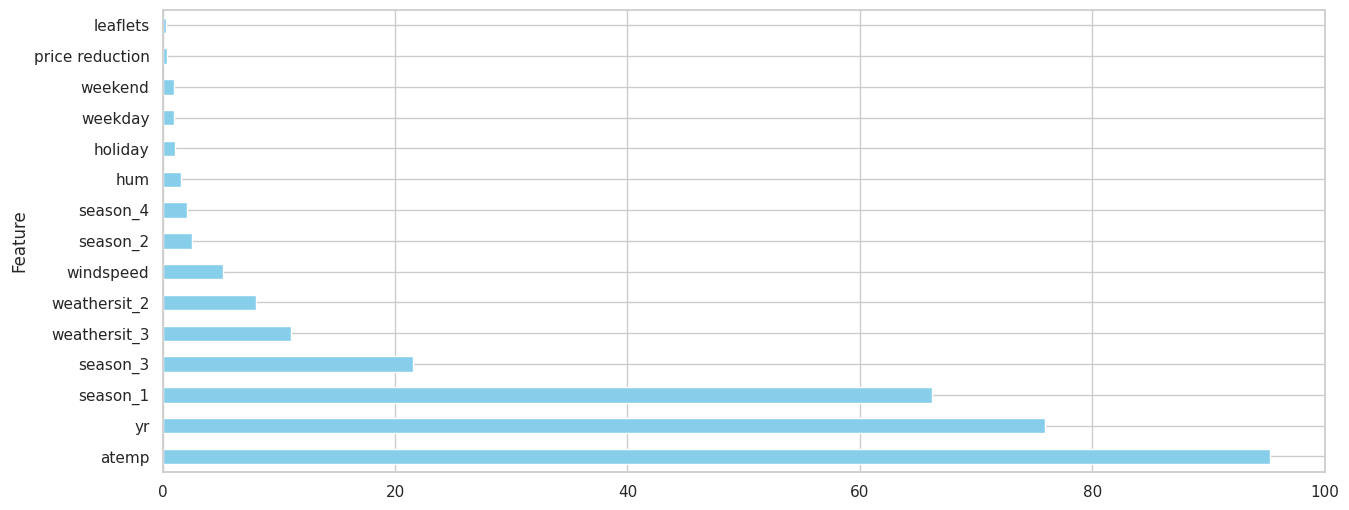

In [81]:
features.nlargest(15, 'Score').plot(kind='barh', x='Feature' ,y='Score', color='skyblue', legend=False, figsize=(15, 6))

Es ist ersichtlich, dass vor allem die Features `atemp`, `yr`, `season_1` und `season_3` sehr bedeutend sind. Gleichermaßen sind Features wie `leaflets` oder `price reduction` kaum relevant.

### 4.1.2 RANSACRegressor

#### Feature Backward Elimination

Für die Feature Selection wenden wir `RFECV` (Recursive Feature Elimination with Cross-Validated) an. Es handelt sich hierbei um einen Feature-Selection-Algorithmus in Scikit-Learn. Er entfernt iterativ weniger wichtige Merkmale und bewertet die Modellleistung durch Kreuzvalidierung. Der Prozess wiederholt sich, bis die gewünschte Anzahl von Merkmalen erreicht ist oder die Modellleistung nicht mehr verbessert wird.

Wir verwenden 5-Fold-Kreuzvalidierung und evaluieren die Modellleistung anhand der negativen mittleren absoluten Fehler `neg_mean_absolute_error`.

In [82]:
recursive_feature_elimination = RFECV(ransac_regressor.estimator_, step=1, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
recursive_feature_elimination.fit(X_train, y_train)

RFECV(cv=5, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_absolute_error')

In [83]:
pd.Series(recursive_feature_elimination.get_feature_names_out().tolist()).to_frame('Selected Features')

,Selected Features
0,season_1
1,season_2
2,season_3
3,season_4
4,weathersit_3
5,atemp
6,yr


Nach Anwendung von `RFECV` verbleiben die aufgeführen Features im Modell.

#### Validation

Nun evaluieren wir das Modell unter Verwendung der festgelegten Werte für die Hyperparameter und der mittels `RFECV` bestimmten Features.

In [84]:
X_train_selected = X_train[recursive_feature_elimination.get_feature_names_out().tolist()]
X_validate_selected = X_validate[recursive_feature_elimination.get_feature_names_out().tolist()]

In [85]:
ransac_regressor = RANSACRegressor(estimator=LinearRegression(), loss='absolute_error', max_trials=150, min_samples=0.6, stop_probability=0.9, random_state=42)

In [86]:
ransac_regressor.fit(X_train_selected, y_train)

RANSACRegressor(estimator=LinearRegression(), max_trials=150, min_samples=0.6,
                random_state=42, stop_probability=0.9)

In [87]:
y_pred = ransac_regressor.predict(X_validate_selected)

In [88]:
measures = performance_measures(y_validate, y_pred, len(ransac_regressor.estimator_.coef_))

R2: 0.23
Adjusted R2: 0.18
MAE: 1143.95
RMSE: 4144.47


In [89]:
feature_selection_measures["Feature_Selection_RANSAC"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

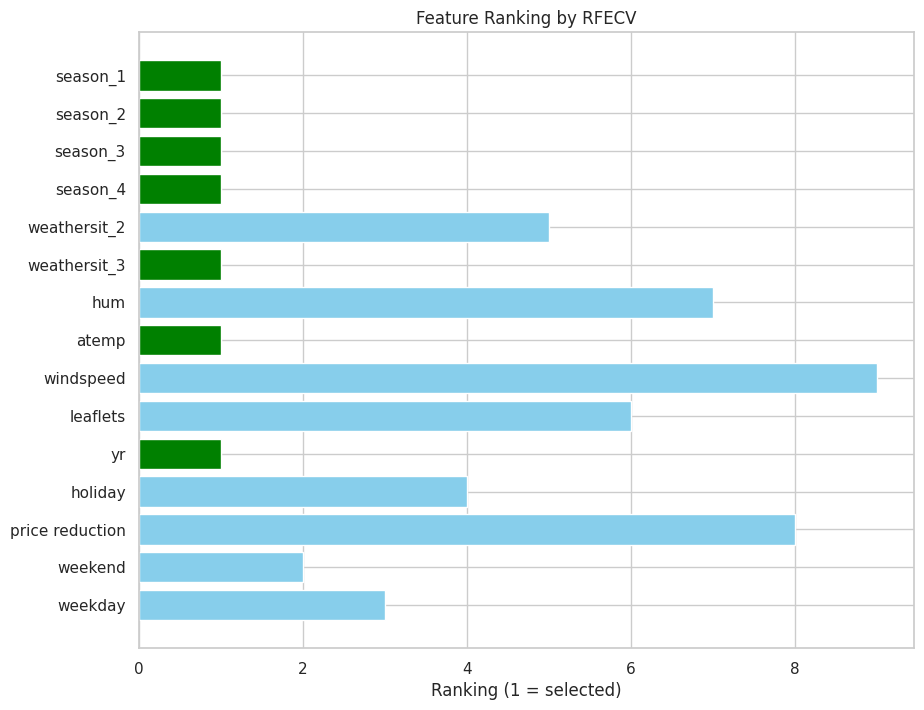

In [90]:
plot_rfecv_feature_ranking(X_train.columns, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

Die Grafik zeigt, in welcher Iteration welches Feature aus dem Modell entfernt wurde. Die grünen Features sind die, die weiterhin im Modell berücksichtigt werden. Die hellblauen Features wurden entfernt. Je höher der Rang, desto früher wurde das Feature entfernt. Hier wurde also im ersten Durchlauf das Feature `windspeed` entfernt, dann `price reduction`, dann `hum` usw.

### 4.1.3 HuberRegressor

#### Feature Backward Elimination

Auch für den `HuberRegressor` wenden wir `RFECV` an, um die Features im Modell zu reduzieren.

In [91]:
recursive_feature_elimination = RFECV(huber_regressor, step=1, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
recursive_feature_elimination.fit(X_train, y_train)

RFECV(cv=5, estimator=HuberRegressor(alpha=0.001, epsilon=1.4, tol=0.001),
      n_jobs=-1, scoring='neg_mean_absolute_error')

In [92]:
pd.Series(recursive_feature_elimination.get_feature_names_out().tolist()).to_frame('Selected Features')

,Selected Features
0,season_1
1,season_2
2,season_4
3,weathersit_2
4,weathersit_3
5,hum
6,atemp
7,windspeed
8,yr
9,holiday


Nach Anwendung von `RFECV` verbleiben die aufgeführen Features im Modell.

#### Validation

Nun evaluieren wir wieder das Modell unter Verwendung der festgelegten Werte für die Hyperparameter und der mittels `RFECV` bestimmten Features.

In [93]:
X_train_selected = X_train[recursive_feature_elimination.get_feature_names_out().tolist()]
X_validate_selected = X_validate[recursive_feature_elimination.get_feature_names_out().tolist()]

In [94]:
huber_regressor = HuberRegressor(alpha=0.001, epsilon=1.4, max_iter=100, tol=0.001)

In [95]:
huber_regressor.fit(X_train_selected, y_train)

HuberRegressor(alpha=0.001, epsilon=1.4, tol=0.001)

In [96]:
y_pred = huber_regressor.predict(X_validate_selected)

In [97]:
measures = performance_measures(y_validate, y_pred, len(huber_regressor.coef_))

R2: 0.24
Adjusted R2: 0.16
MAE: 1086.55
RMSE: 4100.72


In [98]:
feature_selection_measures["Feature_Selection_HUBER"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

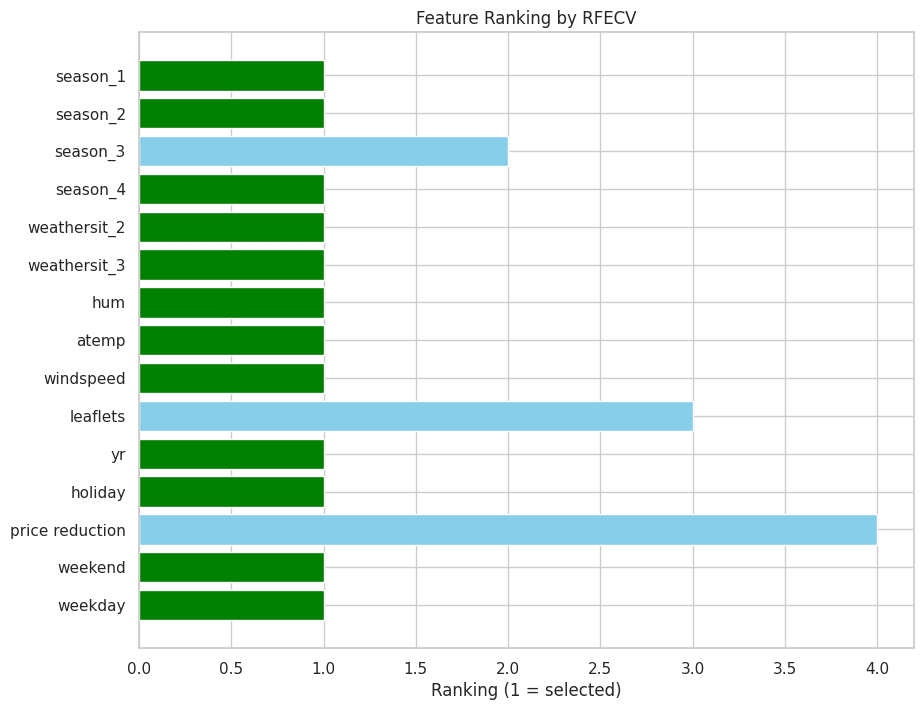

In [99]:
plot_rfecv_feature_ranking(X_train.columns, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

Die Grafik zeigt wieder auf, in welcher Iteration welches Feature aus dem Modell entfernt wurde.

Im folgenden Diagramm ist die Bedeutung der einzelnen verbleibenden Features für das Modell ersichtlich.

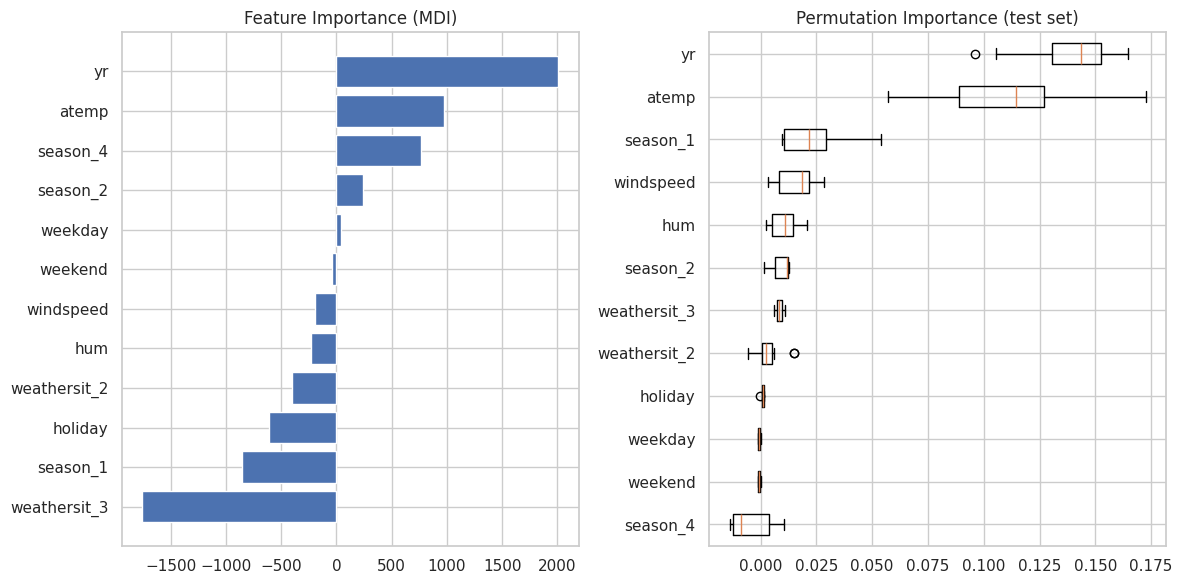

In [100]:
plot_feature_importance(huber_regressor, X_validate_selected, y_validate, X_train_selected)

## 4.2 Without Outliers

### 4.2.1 Feature Importance

Erneut wenden wir die zuvor definierte Funktion `select_top_k_features` an. Anhand der Visualisierung ist ersichtlich, welche Features die bedeutensten sind.


In [101]:
features_no = select_top_k_features(X_train_no, y_train_no, k=15)

<Axes: ylabel='Feature'>

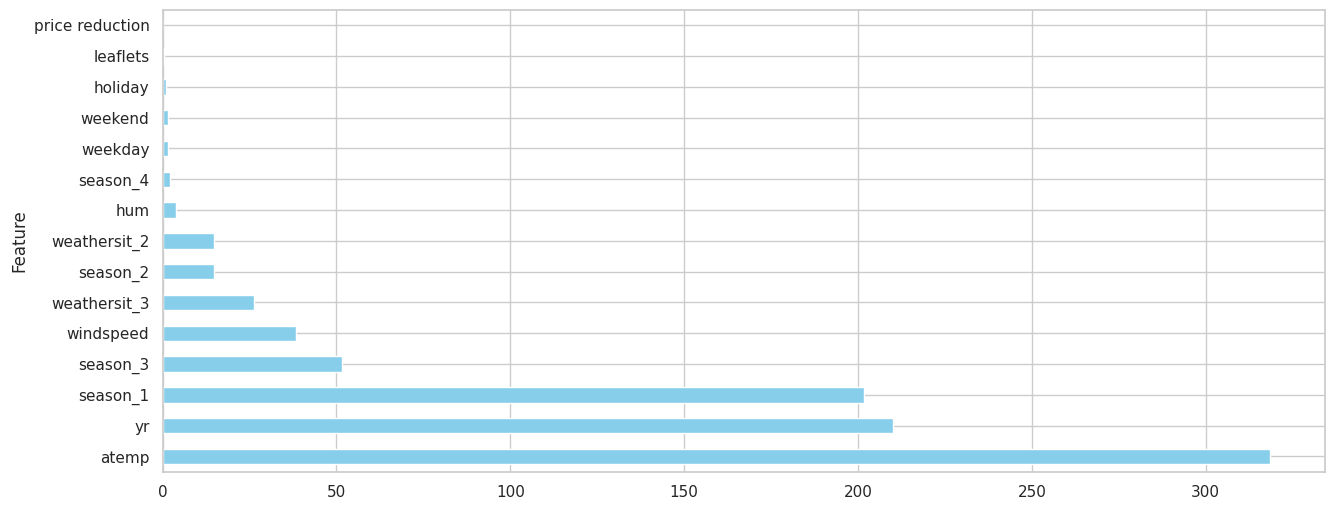

In [102]:
features_no.nlargest(15, 'Score').plot(kind='barh', x='Feature' ,y='Score', color='skyblue', legend=False, figsize=(15, 6))

Es zeigt sich ein ähnliches Bild. Lediglich die genaue Reihenfolge der Features im Mittelfeld unterscheidet sich leicht.

### 4.2.2 GradientBoostingRegressor

#### Feature Backward Elimination

In [103]:
recursive_feature_elimination = RFECV(gradient_boosting_regressor, step=1, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
recursive_feature_elimination.fit(X_train_no, y_train_no)

RFECV(cv=5,
      estimator=GradientBoostingRegressor(learning_rate=0.01,
                                          min_samples_split=4, n_estimators=900,
                                          random_state=42),
      n_jobs=-1, scoring='neg_mean_absolute_error')

In [104]:
pd.Series(recursive_feature_elimination.get_feature_names_out().tolist()).to_frame('Selected Features')

,Selected Features
0,season_1
1,season_2
2,season_3
3,season_4
4,weathersit_2
5,weathersit_3
6,hum
7,atemp
8,windspeed
9,leaflets


Nach Anwendung von `RFECV` verbleiben alle verfügbaren Features im Modell.

Zudem visualisieren wir die Bedeutung der einzelnen Features im Modell. Es ist schnell ersichtlich, dass `price reduction` und `season_2` nahezu keine Bedeutung haben.

<Axes: >

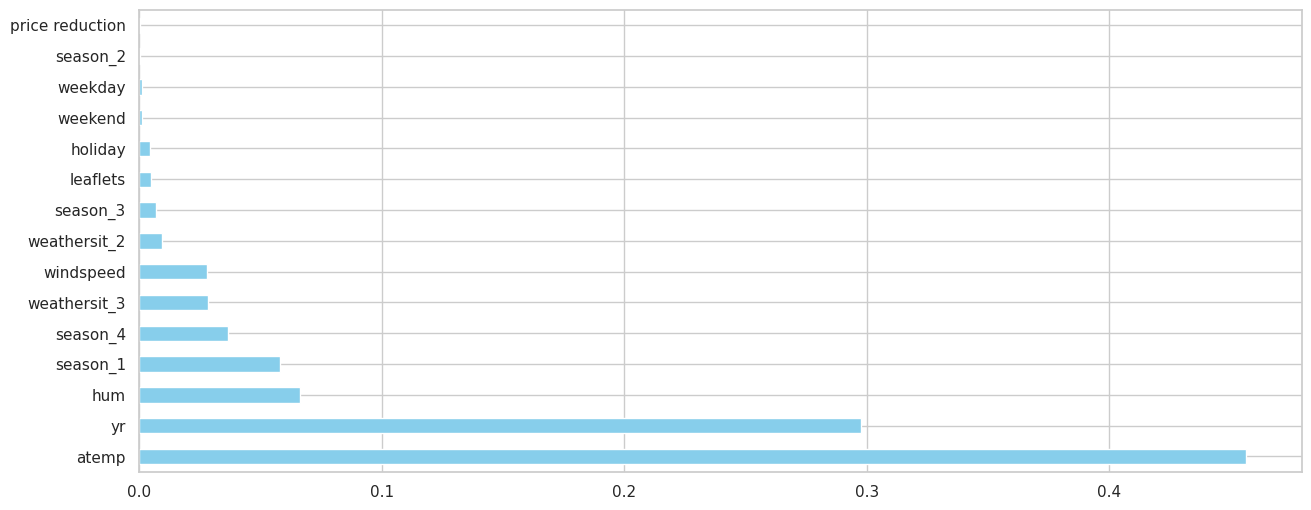

In [105]:
feature_importance = pd.DataFrame(gradient_boosting_regressor.feature_importances_, index=X_train_no.columns, columns=['Importance'])
feature_importance.nlargest(15, 'Importance').plot(kind='barh', color='skyblue', legend=False, figsize=(15, 6))

#### Validation

Nun evaluieren wir wieder das Modell unter Verwendung der festgelegten Werte für die Hyperparameter und der mittels `RFECV` bestimmten Features.

In [106]:
X_train_no_selected = X_train_no[recursive_feature_elimination.get_feature_names_out().tolist()]
X_validate_no_selected = X_validate_no[recursive_feature_elimination.get_feature_names_out().tolist()]

Wir entfernen zusätzlich die beiden Features `price reduction` und `season_2`, die kaum Bedeutung für das Modell haben. Durch diesen Schritt konnte die Performance weiter verbessert werden.

In [107]:
X_train_no_selected.drop(columns=['season_2', 'price reduction'], inplace=True)
X_validate_no_selected.drop(columns=['season_2', 'price reduction'], inplace=True)

In [108]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=900, random_state=42)

In [109]:
gradient_boosting_regressor.fit(X_train_no_selected, y_train_no)

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=4,
                          n_estimators=900, random_state=42)

In [110]:
y_pred = gradient_boosting_regressor.predict(X_validate_no_selected)

In [111]:
measures = performance_measures(y_validate_no, y_pred, len(gradient_boosting_regressor.feature_importances_))

R2: 0.88
Adjusted R2: 0.86
MAE: 493.65
RMSE: 646.28


In [112]:
feature_selection_measures["Feature_Selection_Gradient_Boosting_NO"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

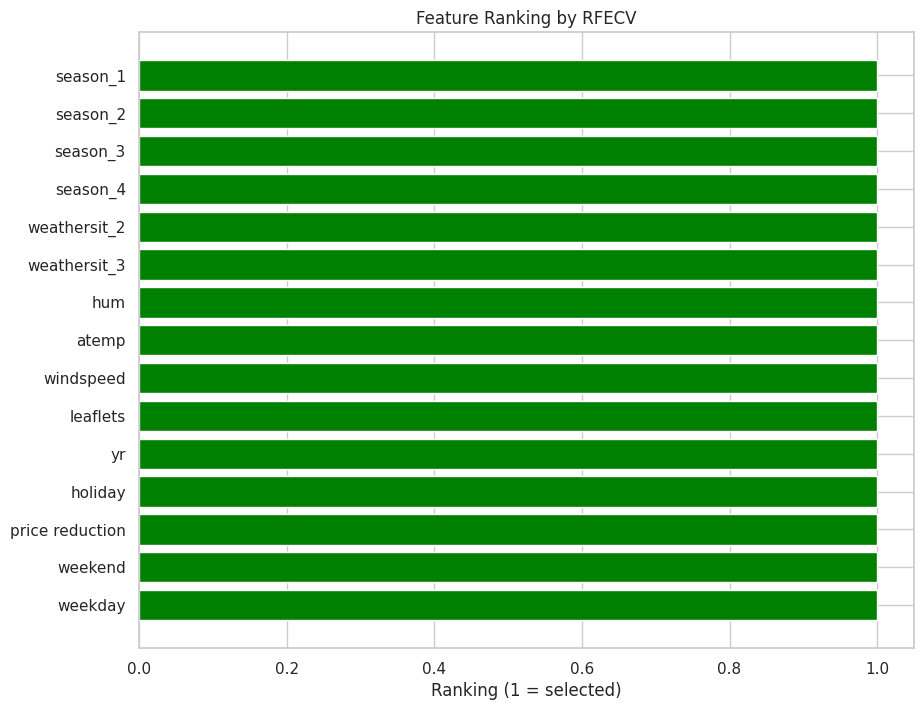

In [113]:
plot_rfecv_feature_ranking(X_train_no.columns, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

Die Grafik zeigt auf, dass nach Anwendung der Backward Elimination keines der Features entfernt wurde.

### 4.2.3 PassiveAggressiveRegressor

#### Feature Backward Elimination

In [114]:
recursive_feature_elimination = RFECV(passive_aggressive_regressor, step=1, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
recursive_feature_elimination.fit(X_train_no, y_train_no)

RFECV(cv=5,
      estimator=PassiveAggressiveRegressor(C=10, max_iter=900,
                                           n_iter_no_change=10,
                                           random_state=42),
      n_jobs=-1, scoring='neg_mean_absolute_error')

In [115]:
pd.Series(recursive_feature_elimination.get_feature_names_out().tolist()).to_frame('Selected Features')

,Selected Features
0,season_1
1,season_2
2,season_3
3,season_4
4,weathersit_2
5,weathersit_3
6,hum
7,atemp
8,windspeed
9,leaflets


Nach Anwendung von `RFECV` verbleiben ebenfalls alle verfügbaren Features im Modell.

Durch die Visualisierung der Bedeutung der einzelnen Features im Modell sehen wir jedoch schnell, dass `price reduction` und `leaflets` nahezu keine Bedeutung haben. Diese beiden Features werden wir im folgenden Schritt entfernen.

<Axes: >

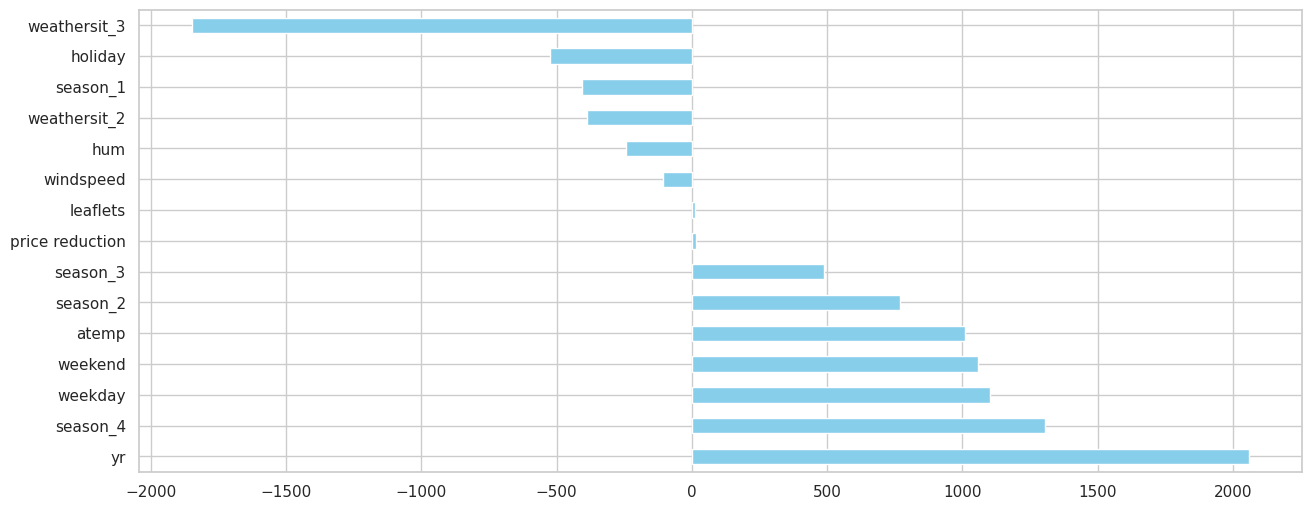

In [116]:
feature_importance = pd.DataFrame(passive_aggressive_regressor.coef_, index=X_train_no.columns, columns=['Importance'])
feature_importance.nlargest(15, 'Importance').plot(kind='barh', color='skyblue', legend=False, figsize=(15, 6))

#### Validation

Nun evaluieren wir wieder das Modell unter Verwendung der festgelegten Werte für die Hyperparameter und der mittels `RFECV` bestimmten Features.

In [117]:
X_train_no_selected = X_train_no[recursive_feature_elimination.get_feature_names_out().tolist()]
X_validate_no_selected = X_validate_no[recursive_feature_elimination.get_feature_names_out().tolist()]

Wir entfernen nun die Features `price reduction` und `leaflets`.

In [118]:
X_train_no_selected.drop(columns=['leaflets', 'price reduction'], inplace=True)
X_validate_no_selected.drop(columns=['leaflets', 'price reduction'], inplace=True)

In [119]:
passive_aggressive_regressor = PassiveAggressiveRegressor(C=10, early_stopping=False, loss='epsilon_insensitive', max_iter=900, n_iter_no_change=10, tol=0.001, validation_fraction=0.1, random_state=42)

In [120]:
passive_aggressive_regressor.fit(X_train_no_selected, y_train_no)

PassiveAggressiveRegressor(C=10, max_iter=900, n_iter_no_change=10,
                           random_state=42)

In [121]:
y_pred = passive_aggressive_regressor.predict(X_validate_no_selected)

In [122]:
measures = performance_measures(y_validate_no, y_pred, len(passive_aggressive_regressor.coef_))

R2: 0.87
Adjusted R2: 0.85
MAE: 532.75
RMSE: 679.80


In [123]:
feature_selection_measures["Feature_Selection_Passive_Aggressive_NO"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

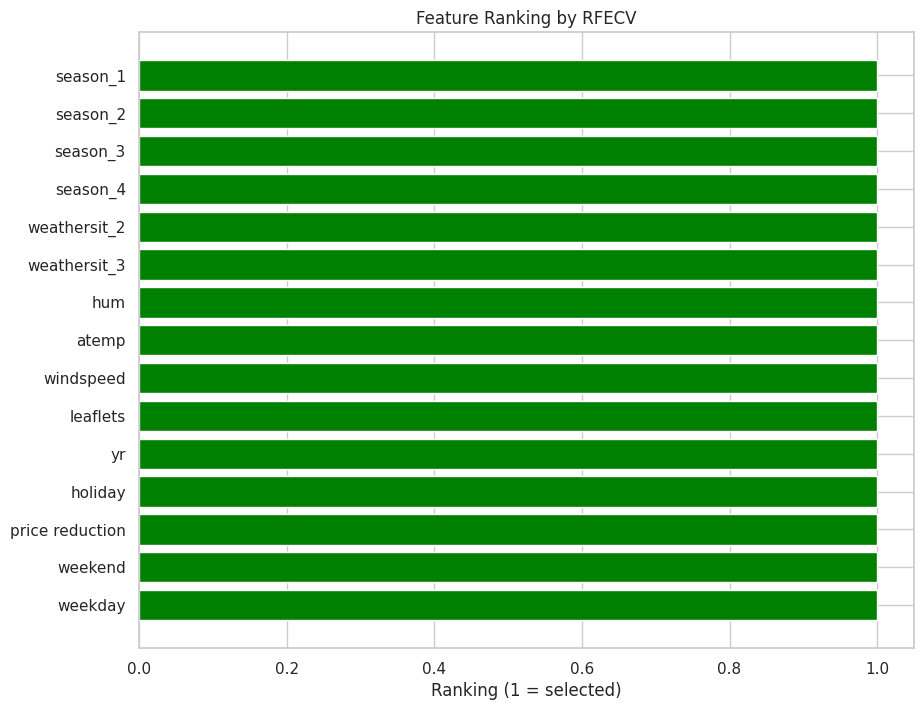

In [124]:
plot_rfecv_feature_ranking(X_train_no, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

Die Grafik zeigt auf, dass nach Anwendung der Backward Elimination keines der Features entfernt wurde.

# 5 Final Model

## 5.1 Ergebnisse nach dem Hyperparameter Tuning:

In der folgenden Darstelllung sind die Performance Measures für alle Modelle nach dem Schritt des Hyperparameter Tunings ersichtlich. 

Auffällig ist, dass die Modelle, die mit Daten trainiert und evaluiert wurden, die um Ausreißer bereinigt wurden, deutlich besser abschneiden.

Die beste Performance bietet der `GradientBoostingRegressor`.

In [125]:
hyperparameter_selection_results = pd.DataFrame(hyperparameter_selection_measures).T
hyperparameter_selection_results.sort_values(by='R2', ascending=False)

,R2,MAE
GridSearch_Gradient_Boosting_NO,0.88,499.22
GridSearch_Passive_Aggressive_NO,0.86,544.47
Baseline_NO,0.86,546.61
GridSearch_RANSAC,0.25,1083.10
GridSearch_Huber,0.24,1085.48
Baseline,0.22,1263.70


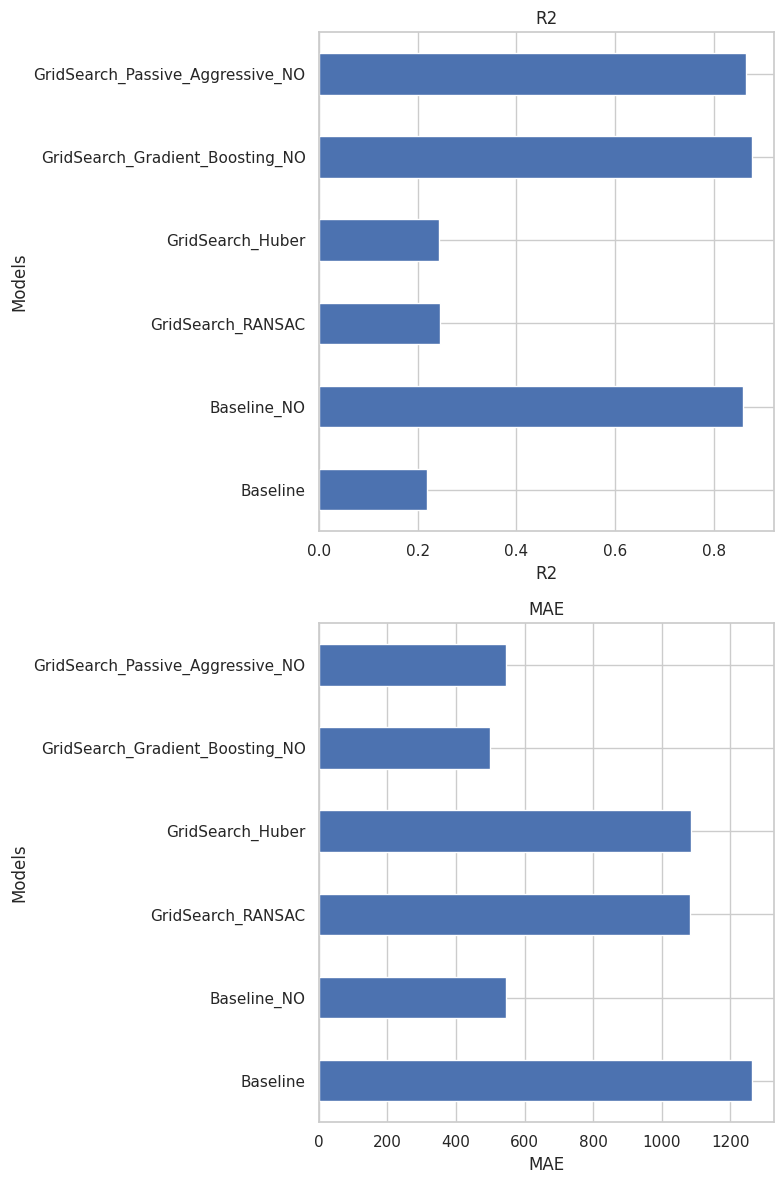

In [126]:
plot_comparative_bar_charts(hyperparameter_selection_results, metrics)

## 5.2 Ergebnisse nach der Feature Selection

In der folgenden Darstelllung sind die Performance Measures für alle Modelle nach dem Schritt der Feature Selection aufgeführt.

Die beste Performance weist erneut der `GradientBoostingRegressor` auf.

In [127]:
feature_selection_results = pd.DataFrame(feature_selection_measures).T
feature_selection_results.sort_values(by='R2', ascending=False)

,R2,MAE
Feature_Selection_Gradient_Boosting_NO,0.88,493.65
Feature_Selection_Passive_Aggressive_NO,0.87,532.75
Baseline_NO,0.86,646.61
Feature_Selection_HUBER,0.24,1086.55
Feature_Selection_RANSAC,0.23,1143.95
Baseline,0.22,1263.70


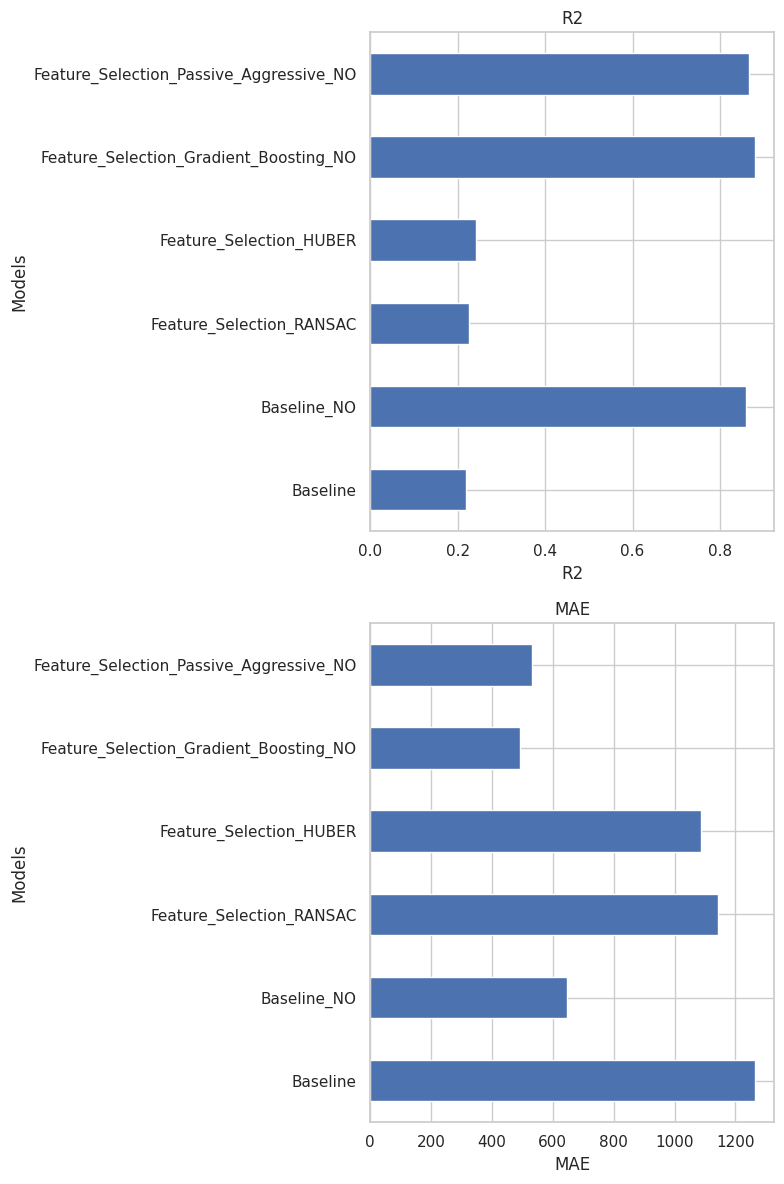

In [128]:
plot_comparative_bar_charts(feature_selection_results, metrics)

## 5.3 Finale Evaluierung auf Testdaten

Für das finale Modell wählen wir aufgrund der Performance Measures den `GradientBoostingRegressor`.

Im Folgenden wird das Modell mit Hilfe der Testdaten evaluiert.

In [129]:
train_data_no_preprocessed = preprocessing_pipeline.fit_transform(train_data_no)
test_data_no_preprocessed = preprocessing_pipeline.transform(test_data_no)

Wir verwenden die folgenden Werte für die vier Hyperparameter:

- **learning_rate**: Die Lernrate wird auf `0,01` festgelegt.
- **max_depth**: Die maximale Tiefe eines einzelnen Entscheidungsbaums beträgt `3`.
- **min_samples_split**: Die minimale Anzahl von erforderlichen Beispielen, um einen Knoten im Entscheidungsbaum zu teilen, beträgt `4`.
- **n_estimators**: Die Anzahl der Bäume im Ensemble beträgt `900`.

In [130]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=900, random_state=42)

In [131]:
recursive_feature_elimination = RFECV(gradient_boosting_regressor, step=1, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
recursive_feature_elimination.fit(train_data_no_preprocessed, train_data_no['cnt'])

RFECV(cv=5,
      estimator=GradientBoostingRegressor(learning_rate=0.01,
                                          min_samples_split=4, n_estimators=900,
                                          random_state=42),
      n_jobs=-1, scoring='neg_mean_absolute_error')

In [132]:
test_data_no_selected = test_data_no_preprocessed[recursive_feature_elimination.get_feature_names_out().tolist()]
train_data_no_selected = train_data_no_preprocessed[recursive_feature_elimination.get_feature_names_out().tolist()]

Wir entfernen lediglich die beiden Features `price reduction` und `season_2`aus dem Modell. Alle anderen verfügbaren Features werden genutzt.

In [133]:
test_data_no_selected.drop(columns=['season_2', 'price reduction'], inplace=True)
train_data_no_selected.drop(columns=['season_2', 'price reduction'], inplace=True)

In [134]:
gradient_boosting_regressor.fit(train_data_no_selected, train_data_no['cnt'])

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=4,
                          n_estimators=900, random_state=42)

In [135]:
y_pred = gradient_boosting_regressor.predict(test_data_no_selected)

In [136]:
measures = performance_measures(test_data_no['cnt'], y_pred, len(gradient_boosting_regressor.feature_importances_))

R2: 0.86
Adjusted R2: 0.85
MAE: 557.45
RMSE: 728.91


Die Performance Measures zeigen, dass das finale Modell eine relativ hohe Erklärungskraft hat 

- **R-Squared**: Der Wert von 0,86 bedeutet, dass das Modell etwa 86% der Varianz in den Zielvariablen erklärt.
- **Adjusted R-Squared**: Der Wert von 0,85 deutet darauf hin, dass das Modell auch unter Berücksichtigung der Anzahl der verwendeten Merkmale gut abschneidet. Das Maß Adjusted R-Squared berücksichtigt die Anzahl der verwendeten Features und korrigiert R-Squared entsprechend.
- **MAE**: Der Wert von 557,45 deutet darauf hin, dass die durchschnittliche Abweichung zwischen Vorhersagen und tatsächlichen Werten etwa 558 Fahrräder beträgt.
- **RMSE**: Der Wert von 728,91 bedeutet, dass der durchschnittliche quadratische Fehler etwa 729 Fahrräder beträgt.

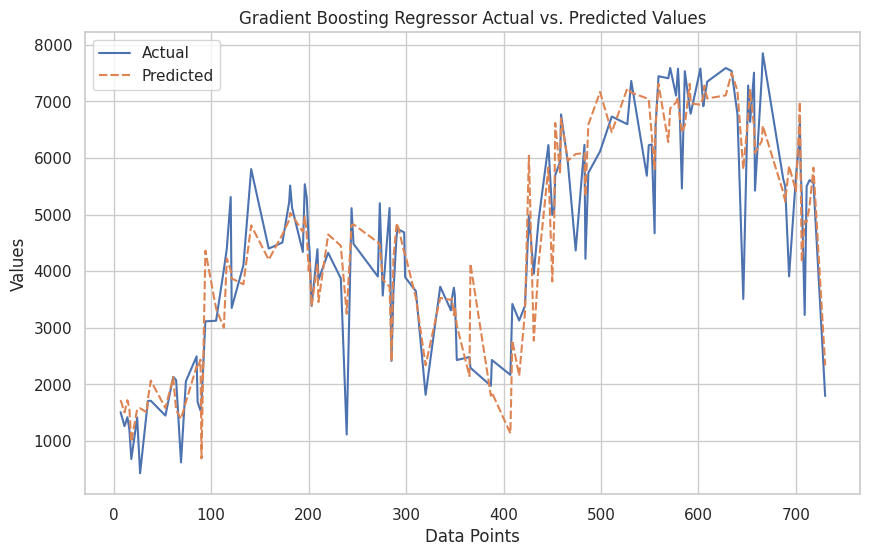

In [137]:
actualVsPredictChart(test_data_no['cnt'], y_pred, "Gradient Boosting Regressor")